In [2]:
pip install tldextract

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
for dirname, _, filenames in os.walk(r'C:\Users\Somashekar\OneDrive\Desktop\PhisShield\dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Somashekar\OneDrive\Desktop\PhisShield\dataset\malicious_phish.csv


In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tldextract
from urllib.parse import urlparse
import re 
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from urllib.parse import urlparse, unquote


In [7]:
# Define the file path
file_path = r'C:\Users\Somashekar\OneDrive\Desktop\PhisShield\dataset\malicious_phish.csv'

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(file_path)

In [8]:
data.head() # Display the first few rows of the DataFrame

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [9]:
data.shape

(651191, 2)

In [10]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [11]:
# Count the number of values for each 'type'
type_counts = data['type'].value_counts()
type_counts

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

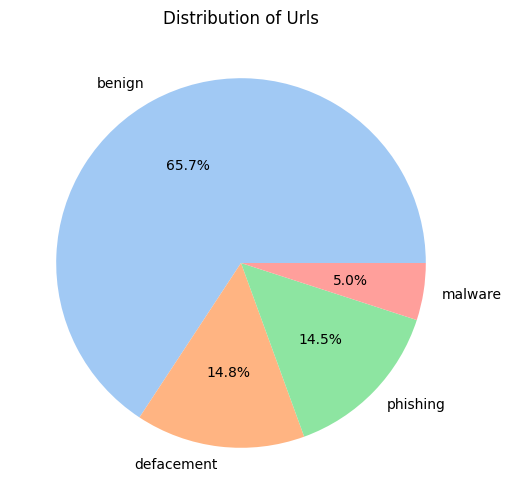

In [12]:
# Assuming you have type_counts as a pandas Series containing the count of each type
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of Urls')
plt.show()

In [13]:
# Remove "www." from URLs and update the 'url' column
data['url'] = data['url'].str.replace('www.', '')

In [14]:
# Print the first few rows of the updated DataFrame
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [15]:
# Create a dictionary to map types to categories
type_to_category = {
    "benign": 0,
    "defacement": 1,
    "phishing": 2,
    "malware": 3
}

# Add a new 'Category' column based on the 'type' column
data['Category'] = data['type'].map(type_to_category)

In [16]:
data.head()

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [17]:
# Add a new 'URL_Length' column with the length of each URL
data['URL_Length'] = data['url'].apply(len)

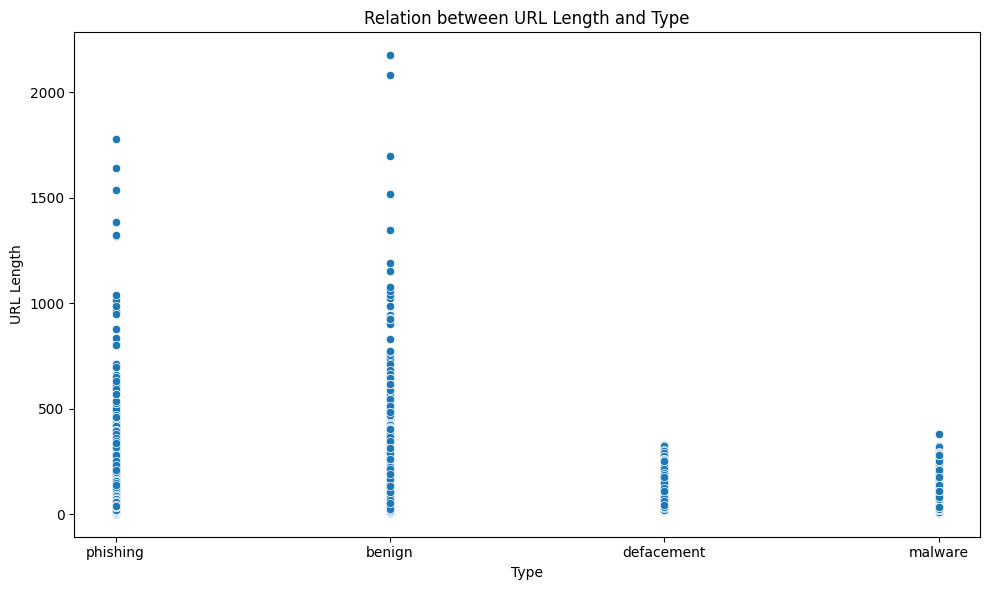

In [18]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='URL_Length')
plt.title("Relation between URL Length and Type")
plt.xlabel("Type")
plt.ylabel("URL Length")
plt.tight_layout()
plt.show()

C:\Users\Somashekar\AppData\Local\Temp\ipykernel_18192\2130253848.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='type', y='URL_Length',palette="bright", ci=None)


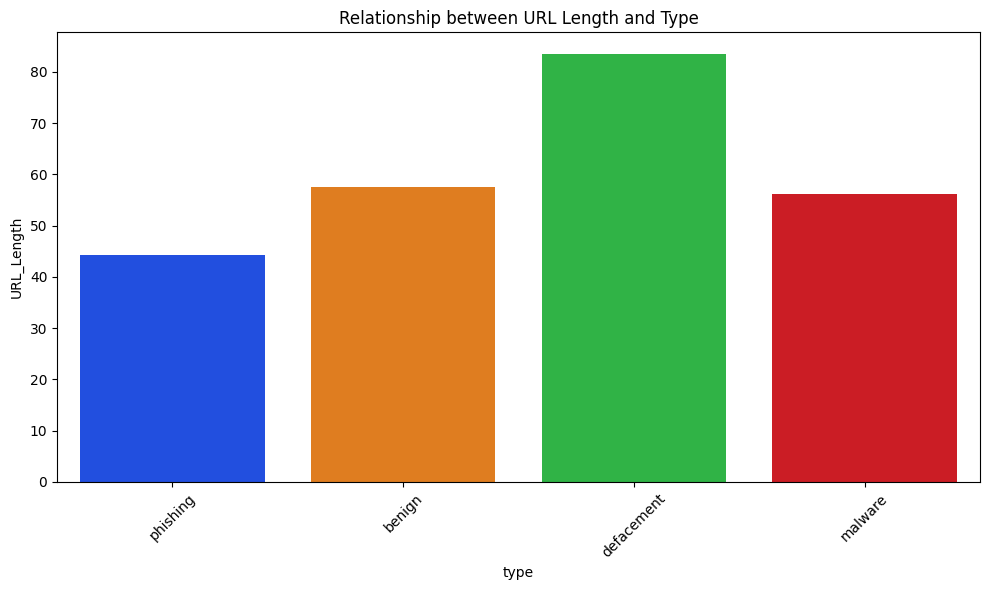

In [19]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='type', y='URL_Length',palette="bright", ci=None)
plt.title("Relationship between URL Length and Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Somashekar\AppData\Local\Temp\ipykernel_18192\1237545503.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='type', y='type_ratio', ci=None, palette='bright')


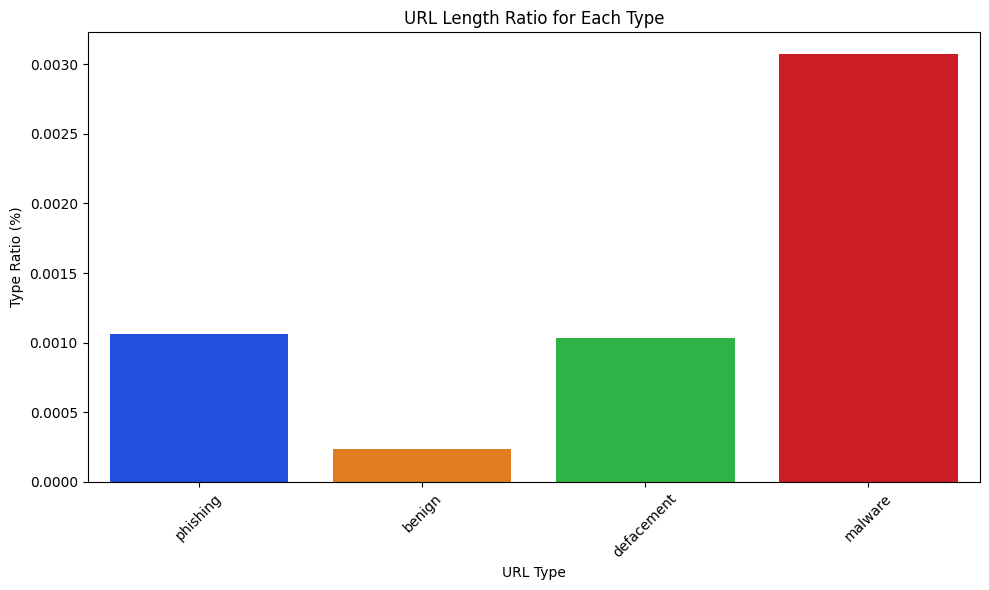

In [20]:
# Calculate the ratios for each URL type within the same type
data['type_ratio'] = data.groupby('type')['URL_Length'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='type', y='type_ratio', ci=None, palette='bright')
plt.title("URL Length Ratio for Each Type")
plt.ylabel("Type Ratio (%)")
plt.xlabel("URL Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
data.head()

,url,type,Category,URL_Length,type_ratio
0,br-icloud.com.br,phishing,2,16,0.000384
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916


In [22]:
# Function to extract domain from URL using tldextract
def extract_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"

# Add a new 'domain' column with the extracted domain from each URL
data['domain'] = data['url'].apply(extract_domain)

In [23]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net


In [24]:
# List of characters to count
characters_to_count = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

# Function to count occurrences of a character in a URL
def count_character_occurrences(url, character):
    return url.count(character)

# Add new columns for each character and count occurrences
for character in characters_to_count:
    data[f'{character}'] = data['url'].apply(lambda url: count_character_occurrences(url, character))


In [25]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [26]:
# Function to detect if there's a match between URL and host
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

# Add a new 'Abnormal_URL' column with 1 if there's a match, 0 otherwise
data['Abnormal_URL'] = data['url'].apply(abnormal_url)

In [27]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,Abnormal_URL
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


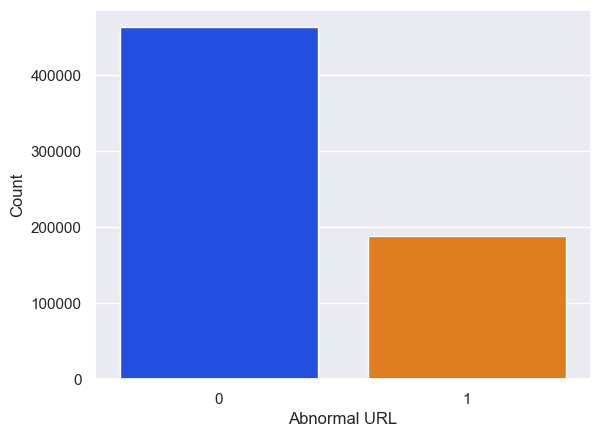

In [28]:
sns.set_theme(style="darkgrid")
sns.countplot(x='Abnormal_URL', data=data, palette="bright")
plt.xlabel('Abnormal URL')
plt.ylabel('Count')
plt.show()

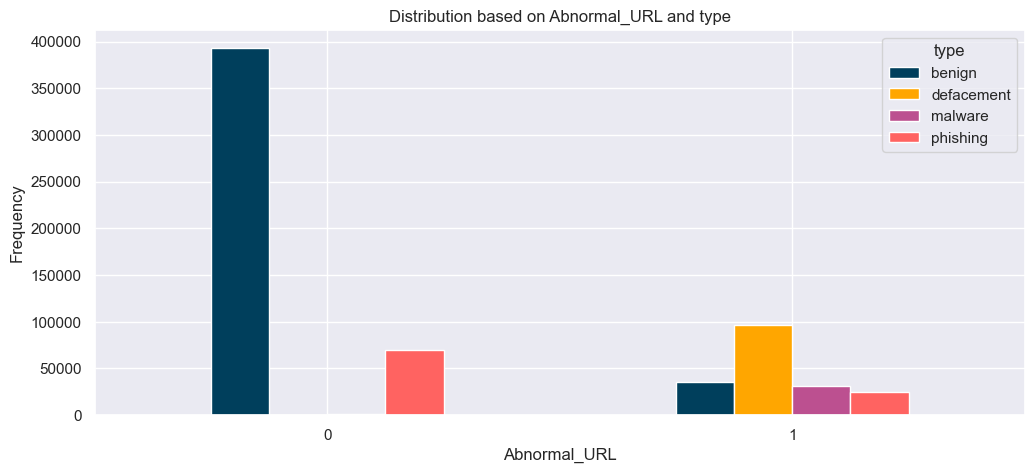

In [29]:
# Create a crosstab and plot the bar chart
pd.crosstab(data["Abnormal_URL"], data["type"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on Abnormal_URL and type')
plt.xlabel('Abnormal_URL')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="type")
plt.show()

In [30]:
# Function to detect if the URL has "https"
def has_https(url):
    return int("https" in url)

# Add a new 'Has_HTTPS' column with 1 if there's "https", 0 otherwise
data['Has_HTTPS'] = data['url'].apply(has_https)

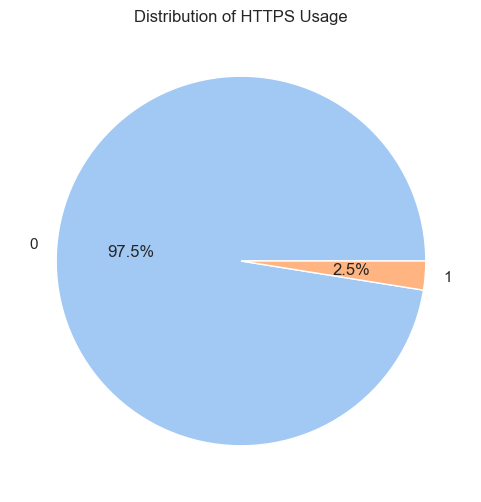

In [31]:
# Count the occurrences of each value in the "Has_HTTPS" column
https_counts = data['Has_HTTPS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(https_counts, labels=https_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of HTTPS Usage')
plt.show()

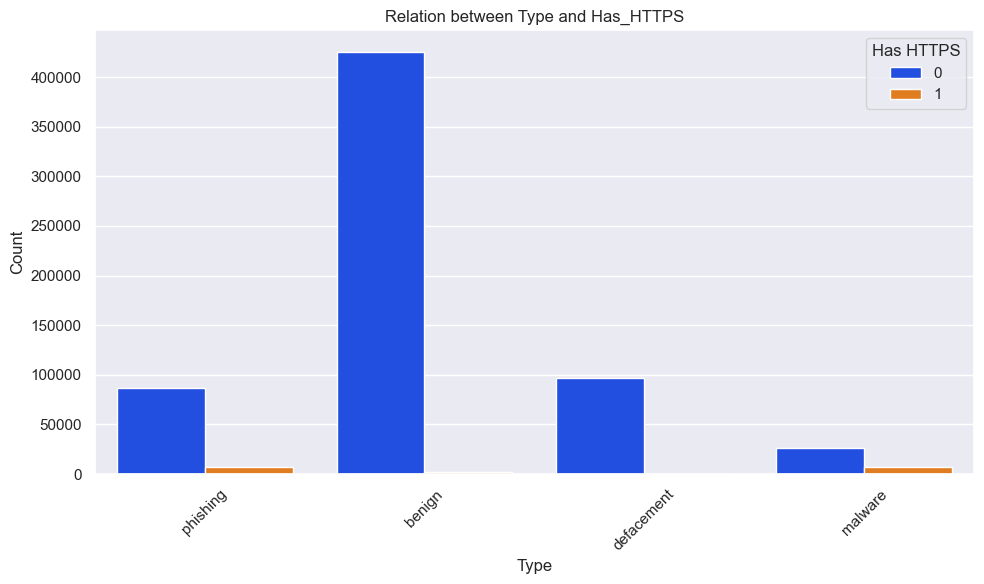

In [32]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_HTTPS',palette="bright")
plt.title("Relation between Type and Has_HTTPS")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has HTTPS")
plt.tight_layout()
plt.show()

In [33]:
# Function to count the number of digits in a string
def count_digits(string):
    return sum(1 for char in string if char.isdigit())

# Function to count the number of letters in a string
def count_letters(string):
    return sum(1 for char in string if char.isalpha())

# Add new columns for digit and letter counts
data['Digit_Count'] = data['url'].apply(count_digits)
data['Letter_Count'] = data['url'].apply(count_letters)

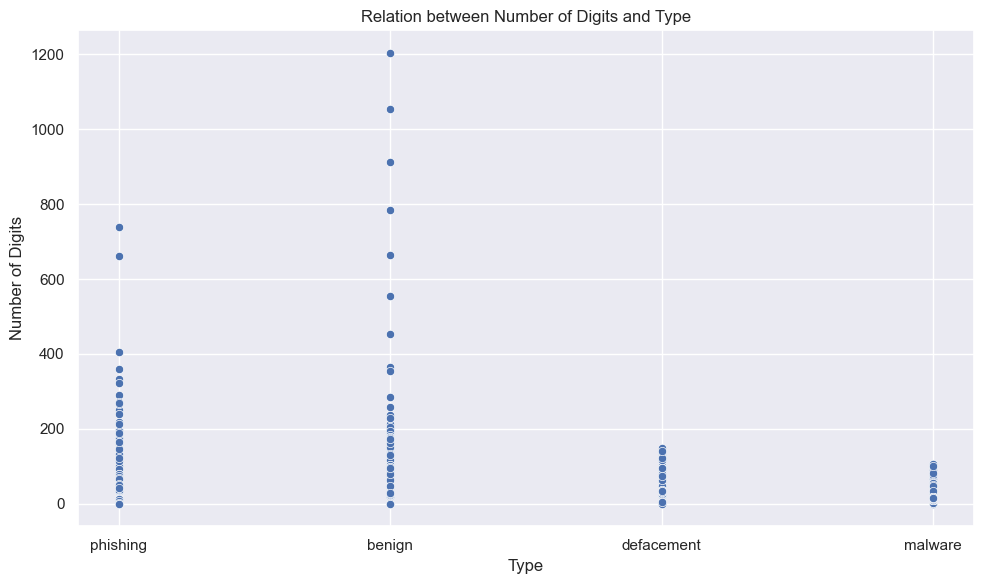

In [34]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='Digit_Count')
plt.title("Relation between Number of Digits and Type")
plt.xlabel("Type")
plt.ylabel("Number of Digits")
plt.tight_layout()
plt.show()

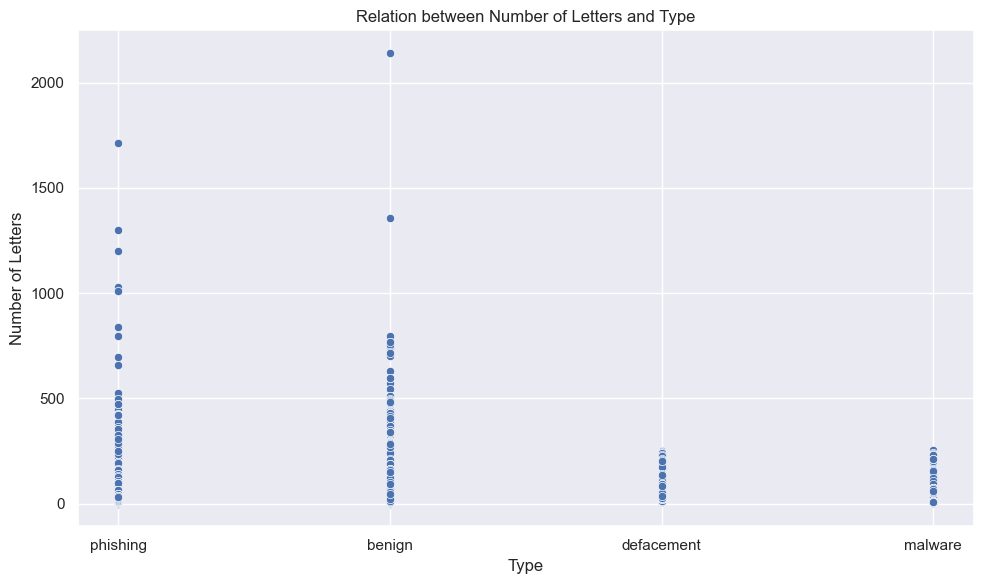

In [35]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='Letter_Count')
plt.title("Relation between Number of Letters and Type")
plt.xlabel("Type")
plt.ylabel("Number of Letters")
plt.tight_layout()
plt.show()

In [36]:
# Define the regular expression pattern for shortening services
shortening_pattern = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                     r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                     r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                     r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                     r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                     r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                     r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                     r'tr\.im|link\.zip\.net'

# Function to detect if the URL uses a shortening service
def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

# Add a new 'Has_Shortening_Service' column with 1 if it has a shortening service, 0 otherwise
data['Has_Shortening_Service'] = data['url'].apply(has_shortening_service)


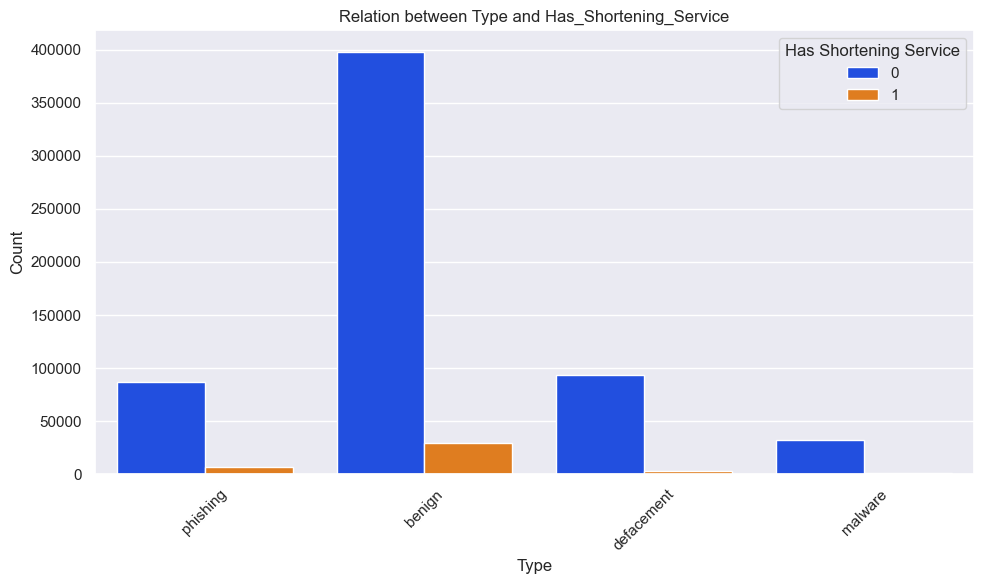

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_Shortening_Service',palette='bright')
plt.title("Relation between Type and Has_Shortening_Service")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()

In [38]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,$,!,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,0,1,1,0,22,199,0


In [39]:
# Define the regular expression pattern to match various IP address formats
ip_pattern = (
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'
    r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
    r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
    r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
)

# Function to detect if the URL has an IP address
def has_ip_address(url):
    return int(re.search(ip_pattern, url, flags=re.I) is not None)

# Add a new 'Has_IP_Address' column with 1 if it has an IP address, 0 otherwise
data['Has_IP_Address'] = data['url'].apply(has_ip_address)

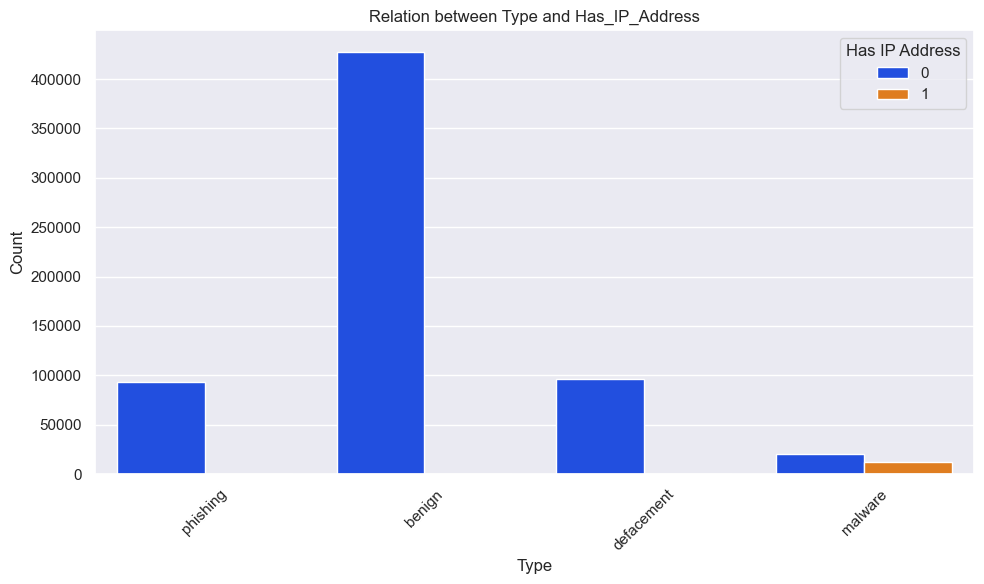

In [40]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_IP_Address',palette='bright')
plt.title("Relation between Type and Has_IP_Address")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()

In [41]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,!,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,1,1,0,22,199,0,0


In [42]:
# Function to check for malicious code in a URL
def check_for_malicious_code(url):
    # Check for 'javascript:' in the URL
    if re.search(r'javascript:', url):
        return 1
    
    # Check for attempts to inject script or use 'on' attributes
    if re.search(r'<\s*script', url, re.IGNORECASE) or re.search(r'on\w*=', url, re.IGNORECASE):
        return 1
    
    return 0

# Add a new 'Has_Malicious_Code' column with 1 if it has malicious code, 0 otherwise
data['Has_javascript_Code'] = data['url'].apply(check_for_malicious_code)


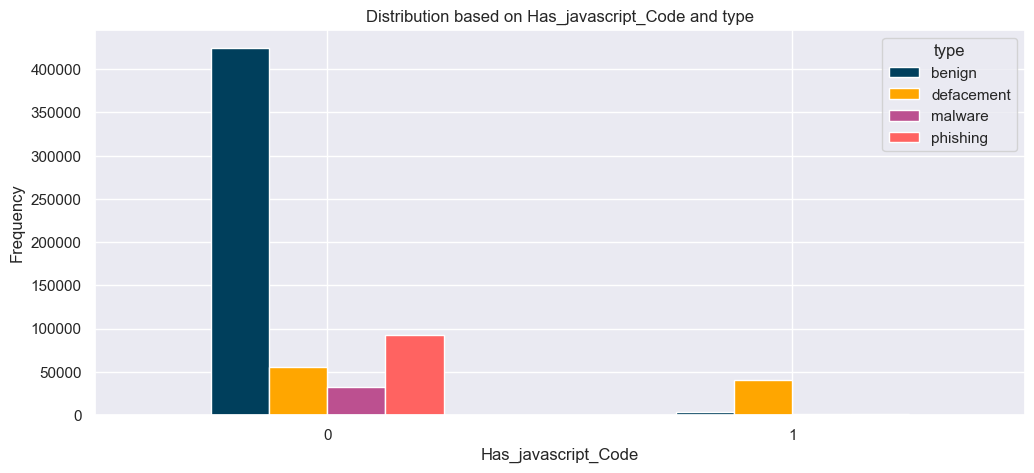

In [43]:
# Create a crosstab and plot the bar chart
pd.crosstab(data["Has_javascript_Code"], data["type"]).plot(kind="bar", figsize=(12, 5),
                                                           color=['#003f5c', '#ffa600', '#bc5090', '#ff6361'])
plt.title('Distribution based on Has_javascript_Code and type')
plt.xlabel('Has_javascript_Code')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="type")
plt.show()

In [44]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,1,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,1,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,1,1,0,7,60,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,1,1,0,22,199,0,0,1


In [45]:
# Define the function to check text encoding
def check_text_encoding(url):
    # Parse the URL
    parsed_url = urlparse(url)

    # Extract the text part
    text_part = parsed_url.path

    # Check for encoding
    decoded_text = unquote(text_part)
    
    # Check if the decoded text matches the original text
    if decoded_text == text_part:
        return 0  # No encoding found
    else:
        return 1  # Encoding found

# Apply the function to the 'url' column and create a new column 'Has_Text_Encoding'
data['Has_Text_Encoding'] = data['url'].apply(check_text_encoding)



In [46]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code,Has_Text_Encoding
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,1,29,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,1,25,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,1,1,0,7,60,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,1,1,0,22,199,0,0,1,0


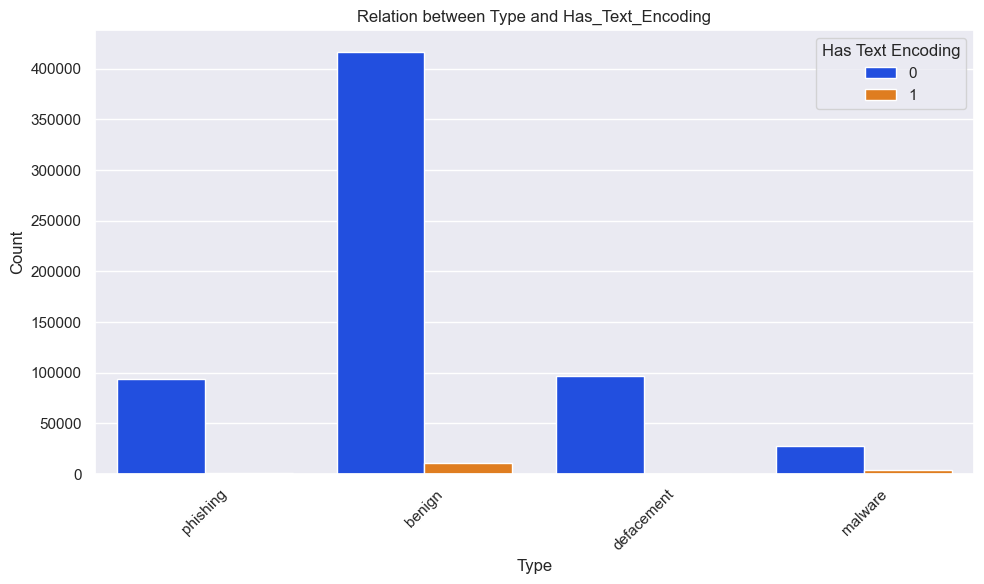

In [47]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_Text_Encoding',palette='bright')
plt.title("Relation between Type and Has_Text_Encoding")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Text Encoding")
plt.tight_layout()
plt.show()

In [49]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

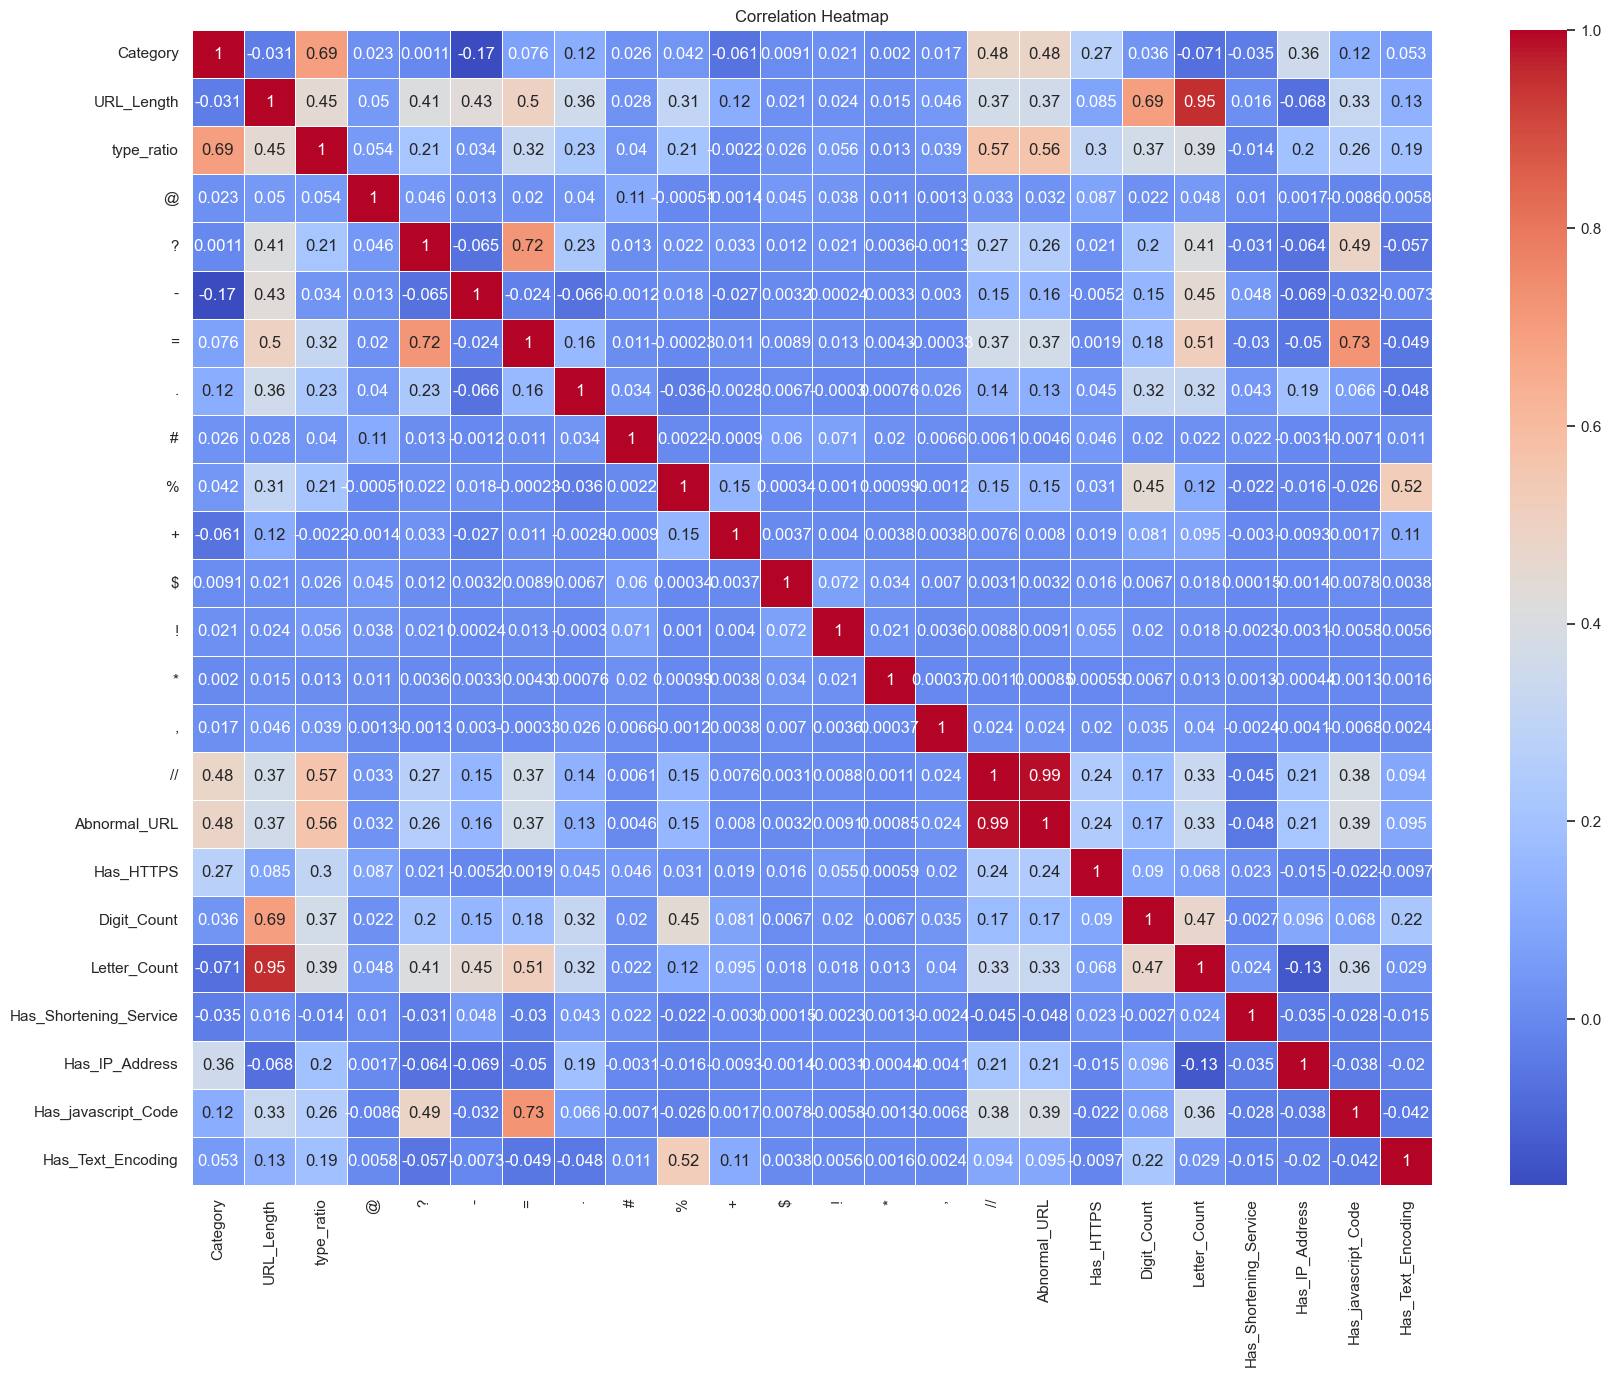

In [50]:
# Calculate correlations between columns
correlation_matrix = numerical_data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

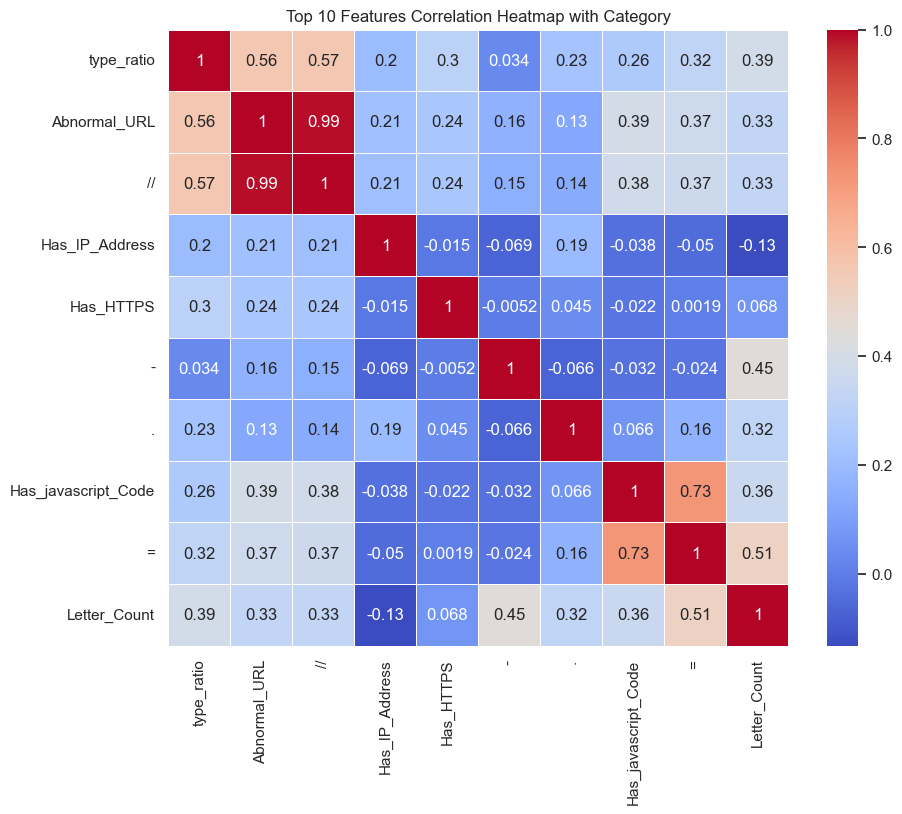

In [53]:
# Select the top 10 features related to the "Category" column
top_features = numerical_data.corr().abs()['Category'].sort_values(ascending=False)[1:11].index

# Calculate correlations for the selected features
correlation_matrix = numerical_data[top_features].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Top 10 Features Correlation Heatmap with Category")
plt.show()

In [54]:
data.isnull().sum()

url                       0
type                      0
Category                  0
URL_Length                0
type_ratio                0
domain                    0
@                         0
?                         0
-                         0
=                         0
.                         0
#                         0
%                         0
+                         0
$                         0
!                         0
*                         0
,                         0
//                        0
Abnormal_URL              0
Has_HTTPS                 0
Digit_Count               0
Letter_Count              0
Has_Shortening_Service    0
Has_IP_Address            0
Has_javascript_Code       0
Has_Text_Encoding         0
dtype: int64

In [55]:
X = data.drop(['url','type','Category','domain','type_ratio','*'],axis=1)#,'type_code'
y = data['Category']

In [56]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (520952, 21)
X_test shape: (130239, 21)
y_train shape: (520952,)
y_test shape: (130239,)


JUST TO TAKE SOME RANDOM SAMPLES TO TEST IN THE predict.py

In [93]:
import random
import math

# Function to randomly select a specified number of instances for testing
def random_sample(data, test_size):
    # Ensure test_size is not larger than the DataFrame
    if isinstance(test_size, float):
        if 0 < test_size < 1:
            test_size = math.ceil(test_size * len(df))
        else:
            raise ValueError("test_size should be a float between 0 and 1, or an integer.")
    elif isinstance(test_size, int):
        if test_size > len(df):
            raise ValueError("test_size is larger than the number of rows in the DataFrame.")
    else:
        raise TypeError("test_size should be a float or an integer.")
    
    # Randomly select indices for the testing sample
    test_indices = random.sample(range(len(df)), test_size)
    
    # Create the testing DataFrame
    test_df = data.iloc[test_indices]
    return test_df

In [97]:
test_df=random_sample(data,0.2)
test_df


,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code,Has_Text_Encoding
122666,irishecho.com/?p=67700,benign,0,22,0.000089,irishecho.com,0,1,0,1,...,0,0,0,0,5,13,0,0,0,0
100888,http://brastampas.com.br/index.php?option=com_...,defacement,1,91,0.001129,brastampas.com.br,0,1,0,5,...,0,1,1,0,5,68,0,0,1,0
58612,vip-computer.com,phishing,2,16,0.000384,vip-computer.com,0,0,1,0,...,0,0,0,0,0,14,0,0,0,0
125395,tttfaero.com,phishing,2,12,0.000288,tttfaero.com,0,0,0,0,...,0,0,0,0,0,11,0,0,0,0
122907,nanomedicine.com/NMI/Foreword.htm,benign,0,33,0.000134,nanomedicine.com,0,0,0,0,...,0,0,0,0,0,29,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102806,buimerccorp.com,phishing,2,15,0.000360,buimerccorp.com,0,0,0,0,...,0,0,0,0,0,14,0,0,0,0
98903,songlyrics.com/88-fingers-loui/two-faced-basta...,benign,0,56,0.000227,songlyrics.com,0,0,5,0,...,0,0,0,0,2,45,0,0,0,0
105129,vincentwardfilms.com/,benign,0,21,0.000085,vincentwardfilms.com,0,0,0,0,...,0,0,0,0,0,19,0,0,0,0
35953,guardian.co.uk/stage/tamara-rojo,benign,0,32,0.000130,guardian.co.uk,0,0,1,0,...,0,0,0,0,0,27,0,0,0,0


In [96]:
X_test.columns


Index(['URL_Length', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', ',',
       '//', 'Abnormal_URL', 'Has_HTTPS', 'Digit_Count', 'Letter_Count',
       'Has_Shortening_Service', 'Has_IP_Address', 'Has_javascript_Code',
       'Has_Text_Encoding'],
      dtype='object')

In [57]:
data.columns

Index(['url', 'type', 'Category', 'URL_Length', 'type_ratio', 'domain', '@',
       '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//',
       'Abnormal_URL', 'Has_HTTPS', 'Digit_Count', 'Letter_Count',
       'Has_Shortening_Service', 'Has_IP_Address', 'Has_javascript_Code',
       'Has_Text_Encoding'],
      dtype='object')

In [58]:
# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (520952, 21)
X_test shape: (130239, 21)
y_train shape: (520952,)
y_test shape: (130239,)


In [59]:

# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9144035196830442


In [83]:

# Save the trained model using joblib
joblib.dump(clf, 'trained_models\malicious_url_model_rfclf.joblib')

['malicious_url_model_rfclf.joblib']

In [60]:
# Initialize and train the AdaBoostClassifier
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_ada = ada_classifier.predict(X_test)

# Calculate the accuracy of the AdaBoost model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("AdaBoost Accuracy:", accuracy_ada)

AdaBoost Accuracy: 0.8092046161288093


In [84]:
joblib.dump(ada_classifier, 'trained_models\malicious_url_model_adaclf.joblib')

['trained_models\\malicious_url_model_adaclf.joblib']

In [61]:
# Initialize and train the SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_sgd = sgd_classifier.predict(X_test)

# Calculate the accuracy of the SGD model
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("SGD Classifier Accuracy:", accuracy_sgd)

SGD Classifier Accuracy: 0.8215511482735586


In [85]:
joblib.dump(sgd_classifier, 'trained_models\malicious_url_model_sgdclf.joblib')

['trained_models\\malicious_url_model_sgdclf.joblib']

In [62]:
# Initialize and train the ExtraTreesClassifier
extra_trees_classifier = ExtraTreesClassifier(random_state=42)
extra_trees_classifier.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_extra_trees = extra_trees_classifier.predict(X_test)

# Calculate the accuracy of the ExtraTrees model
accuracy_extra_trees = accuracy_score(y_test, y_pred_extra_trees)
print("ExtraTrees Classifier Accuracy:", accuracy_extra_trees)

ExtraTrees Classifier Accuracy: 0.914196208508972


In [86]:
joblib.dump(extra_trees_classifier, 'trained_models\malicious_url_model_extratreeclf.joblib')

['trained_models\\malicious_url_model_extratreeclf.joblib']

In [63]:
pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 1.35.13 requires typing-extensions<5,>=4.7, but you have typing-extensions 4.5.0 which is incompatible.
pydantic 2.7.1 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.18.2 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.3.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0


In [64]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [67]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=2)  # You can adjust the number of epochs and batch size

Epoch 1/2
260476/260476 [==============================] - 742s 3ms/step - loss: -5727949.5000 - accuracy: 0.5490
Epoch 2/2
260476/260476 [==============================] - 435s 2ms/step - loss: -84511240.0000 - accuracy: 0.5506


In [68]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

4070/4070 [==============================] - 6s 1ms/step - loss: -179427984.0000 - accuracy: 0.5563
Test accuracy: 55.63%


RUN THIS AFTER TRAINING THE NEURAL NETWORK FOR MORE EPOCHS


In [ ]:
# joblib.dump(model, 'trained_models\malicious_url_model_neuralnetwork.joblib')